In [1]:
import pandas as pd
import numpy as np

import matplotlib.cm as cm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score, fbeta_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [2]:
sepsis_df = pd.read_pickle("../data/sepsis_df_median_imputed.pkl")

# create X and y for model
X = sepsis_df.drop(columns=['isSepsis'])
y = sepsis_df.isSepsis

# splitting data into Train, Val, & Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=248)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=248)

In [3]:
# # resampling using random oversampling
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=0)

# X_train, y_train = ros.fit_resample(X_train,y_train)

In [4]:
# resampling using SMOTE
from imblearn.over_sampling import SMOTE

X_train, y_train = SMOTE(random_state=42).fit_resample(X_train,y_train)

In [5]:
from collections import Counter
Counter(y_train)

Counter({0: 21519, 1: 21519})

In [6]:
Counter(y)

Counter({0: 33655, 1: 2647})

### Random Forest

In [7]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [8]:
y_train_pred = rf.predict(X_train)
y_val_pred = rf.predict(X_val)

In [9]:
def scores(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fbeta = fbeta_score(y_true, y_pred, beta=2)

    print(f'Accuracy score: {accuracy}')
    print(f'Precision score: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')
    print(f'F-beta (beta=2): {fbeta}')

#### Train Set Scores

In [10]:
scores(y_train, y_train_pred)

Accuracy score: 1.0
Precision score: 1.0
Recall: 1.0
F1: 1.0
F-beta (beta=2): 1.0


#### Validation Set Scores

In [11]:
scores(y_val, y_val_pred)

Accuracy score: 0.9678085729041143
Precision score: 0.7816377171215881
Recall: 0.7608695652173914
F1: 0.7711138310893514
F-beta (beta=2): 0.7649344341913551


In [12]:
y_pred = rf.predict(X)

In [13]:
scores(y, y_pred)

Accuracy score: 0.9878243622940884
Precision score: 0.9228998849252014
Recall: 0.9089535323007178
F1: 0.9158736200989722
F-beta (beta=2): 0.9117089806744979


### Precision & Recall Curve

In [14]:
plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True)

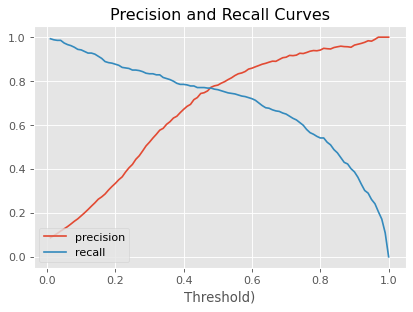

In [15]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, rf.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold)');
plt.title('Precision and Recall Curves');

### RF Confusion Matrix

In [16]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
    sepsis_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(sepsis_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['No Sepsis', 'Sepsis'],
           yticklabels=['No Sepsis', 'Sepsis']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.title('Logistic Regression confusion matrix');

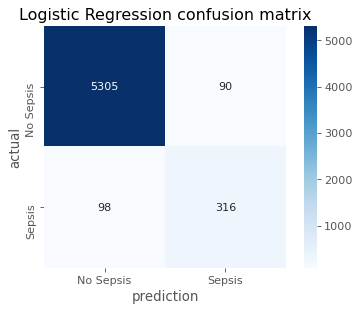

In [17]:
make_confusion_matrix(rf)

In [18]:
def make_confusion_matrix_all(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X)[:, 1] >= threshold)
    sepsis_confusion = confusion_matrix(y, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(sepsis_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['No Sepsis', 'Sepsis'],
           yticklabels=['No Sepsis', 'Sepsis']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.title('Logistic Regression confusion matrix');

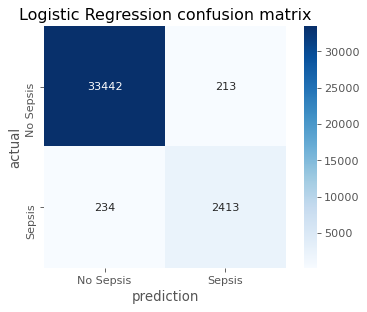

In [19]:
make_confusion_matrix_all(rf)

In [20]:
from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix_all(rf, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

### ROC Curve

In [21]:
fpr, tpr, thresholds = roc_curve(y_val, rf.predict_proba(X_val)[:,1])

ROC AUC score =  0.9472124842737729


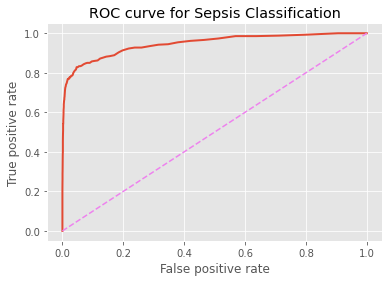

In [22]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Sepsis Classification');
print("ROC AUC score = ", roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))

### Log Loss

In [23]:
print("Log-loss on Random Forest Model: {:6.4f}".format(log_loss(y_val, rf.predict_proba(X_val))))

Log-loss on Random Forest Model: 0.1477


### Feature Importance

In [24]:
feature_importance_df = pd.DataFrame({'feat_importance':rf.feature_importances_}, index=X_val.columns).sort_values(by='feat_importance', ascending=False)

In [25]:
feature_importance_df

,feat_importance
ICULOS,0.213926
BUN,0.072011
Creatinine,0.064413
Hgb,0.062928
Platelets,0.059909
Hct,0.051486
Magnesium,0.043967
WBC,0.043864
Calcium,0.034649
O2Sat,0.031326
